In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST, VesselMNIST3D
import cProfile
from torchvision import transforms
from copy import copy

Please install the required packages first. Use `pip install -r requirements.txt`.


In [ ]:
# Synthetic Data
shape, ranks, separation_rank = (64, 64), (8, 8), 2
loss_fn = f.mse_loss

sample_size = 2000
val_sample_size = 500
clients = 10

synth_dataset, synth_val_dataset = synthesize_data(shape, ranks, separation_rank,\
                                                   sample_size, val_sample_size)
synth_client_datasets = federate_dataset(synth_dataset, clients)
synth_data = (synth_dataset, synth_client_datasets, synth_val_dataset)

In [ ]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2
loss_fn = logistic_loss

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 10)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)
breast_data = (breast_dataset, breast_client_datasets, breast_val_dataset)

print("fraction positive: ", sum(breast_val_dataset[:, 0][1]) / len(breast_val_dataset[:, 0][1]))

In [ ]:
# Vessel MNIST 3D
vessel_dataset = VesselMNIST3D(split="train", download=True)
vessel_val_dataset = VesselMNIST3D(split="val", download=True)
vessel_client_datasets = federate_dataset(vessel_dataset, 10)
vessel_data = (vessel_dataset, vessel_client_datasets, vessel_val_dataset)
print([len(c) for c in vessel_client_datasets])
print("fraction positive: ", sum(vessel_val_dataset[:, 0][1]) / len(vessel_val_dataset[:, 0][1]))

In [ ]:
# Tuning
iters = 100
n_workers = 4
n_runs = 4

path_base = "../data/vessel_tuning"
dataset, client_datasets, val_dataset = vessel_data
loss_fn = logistic_loss
aggregator_fn = avg_aggregation

shape, ranks, separation_rank = (28, 28, 28), (3, 3, 3), 2
steps = 10
lr = 0.001
momentum = 0.99

hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": lr, "momentum": momentum, "steps": steps, "threshold": 0.0}
lsr_dot_params = (shape, ranks, separation_rank, torch.float64, torch.device('cuda'))

print(f"Training lr {lr} steps {steps} momentum {momentum}")
path = f"{path_base}/lr{int(lr*1000)}_mom{momentum}_steps{steps}"
args = (lsr_bcd_regression, lsr_dot_params, loss_fn, dataset, val_dataset, hypers, True)

run_test(path, n_runs, n_workers, *args)
        

In [2]:
# Comparison of federated algos
shape, ranks, separation_rank = (64, 64), (8, 8), 2
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))

loss_fn = f.mse_loss
aggregator_fn = avg_aggregation

site_sizes = [20, 100, 200, 300, 400, 500, 1000]
iters = 100

n_runs = 5
n_trials = 8
n_workers = 8

path_base = "../data/synth_size_test"

def data_fn_by_size(sample_size, val_sample_size=500, clients=8):
    synth_tensor = get_synth_tensor(shape, ranks, separation_rank)
    synth_dataset, synth_val_dataset = synthesize_data(synth_tensor, sample_size*clients, val_sample_size)
    synth_client_datasets = federate_dataset(synth_dataset, clients)
    return (synth_dataset, synth_val_dataset, synth_client_datasets)
    
methods = [BCD_avg_local, lsr_bcd_regression, BCD_federated_stepwise, BCD_federated_all_factors, BCD_federated_full_iteration, BCD_federated_full_iteration]
names = ['local', 'centralized', 'step', 'factors_core', 'one_iter', 'five_iter']

gen_hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_5_hypers = {"max_rounds": iters // 5, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

arg_list = [(gen_hypers, loss_fn, False), # local
            (gen_hypers, loss_fn, False), # centralized
            (gen_hypers, loss_fn, aggregator_fn, False), # one step
            (gen_hypers, loss_fn, aggregator_fn, False), # factors core
            (iter_hypers, loss_fn, aggregator_fn, False), # one iter
            (iter_5_hypers, loss_fn, aggregator_fn, False)] # five iter

for size in site_sizes:
    def data_fn():
        return data_fn_by_size(size)

    sized_names = [f"{name}_{size}" for name in names]
        
    run_combined_test(path_base, n_runs, n_trials, n_workers, data_fn, lsr_dot_params, sized_names, methods, arg_list)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4
Run 0
Run 1
Run 2
Run 3
Run 4


In [10]:
#Load data from runs
path_base = "../data/synth_size_test"
size = 1000
names = [f"centralized_{size}", f"step_{size}", f"factors_core_{size}", f"one_iter_{size}", f"five_iter_{size}", f"local_{size}"]
print(names)
#names = [f"lr{int(lr*1000)}_mom{momentum}" for momentum in [0.0, 0.9, 0.99] for lr in [0.1, 0.003, 0.001]]

train_losses, train_std = [], []
val_losses, val_std = [], []

train_accs, train_acc_std = [], []
val_accs, val_acc_std = [], []

for name in names:
    path = f"{path_base}/{name}"
    train_losses.append(torch.mean(torch.load(f"{path}/train_loss"), axis=0))
    train_std.append(torch.std(torch.load(f"{path}/train_loss"), axis=0))
    
    val_losses.append(torch.mean(torch.load(f"{path}/val_loss"), axis=0))
    val_std.append(torch.std(torch.load(f"{path}/val_loss"), axis=0))

    #train_accs.append(torch.mean(torch.load(f"{path}/train_acc"), axis=0))
    #train_acc_std.append(torch.std(torch.load(f"{path}/train_acc"), axis=0))
    
    #val_accs.append(torch.mean(torch.load(f"{path}/val_acc"), axis=0))
    #val_acc_std.append(torch.std(torch.load(f"{path}/val_acc"), axis=0))
    
print("Loaded run data")
print([vl.shape for vl in val_losses])

['centralized_1000', 'step_1000', 'factors_core_1000', 'one_iter_1000', 'five_iter_1000', 'local_1000']
Loaded run data
[torch.Size([100]), torch.Size([100]), torch.Size([100]), torch.Size([100]), torch.Size([20]), torch.Size([100])]


In [3]:
#Load data from runs (site size comparison)
path_base = "../data/synth_size_test"

site_sizes = [20, 100, 200, 300, 400, 500, 1000]

train_losses, train_std = [], []
val_losses, val_std = [], []

names = [f"centralized", f"step", f"factors_core", f"one_iter", f"five_iter", f"local"]

for name in names:
    size_best_train, size_best_train_std = [], []
    size_best_val, size_best_val_std = [], []

    for size in site_sizes:
        full_name = f"{name}_{size}"    
        path = f"{path_base}/{full_name}"
        
        size_best_train.append(torch.mean(torch.load(f"{path}/train_loss").min(dim=1).values))
        size_best_train_std.append(torch.std(torch.load(f"{path}/train_loss").min(dim=1).values))
        
        size_best_val.append(torch.mean(torch.load(f"{path}/val_loss").min(dim=1).values))
        size_best_val_std.append(torch.std(torch.load(f"{path}/val_loss").min(dim=1).values))

    train_losses.append(torch.stack(size_best_train))
    train_std.append(torch.stack(size_best_train_std))
    val_losses.append(torch.stack(size_best_val))
    val_std.append(torch.stack(size_best_val_std))
    
print("Loaded run data")
print([vl.shape for vl in val_losses])

Loaded run data
[torch.Size([7]), torch.Size([7]), torch.Size([7]), torch.Size([7]), torch.Size([7]), torch.Size([7])]


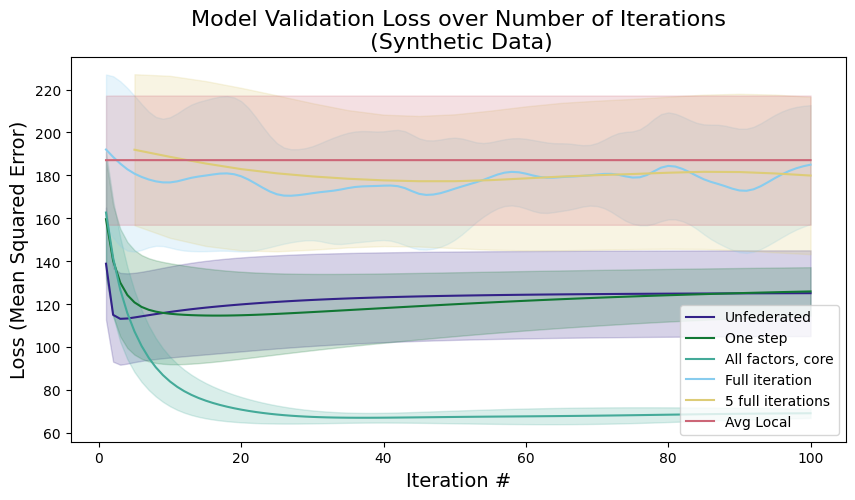

In [11]:
colors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#5D070A"]
labels = ["Unfederated", "One step", "All factors, core", "Full iteration", "5 full iterations", "Avg Local"]
#labels = names

xscales = [1, 1, 1, 1, 5, 1]
#xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]

metrics = val_losses
stds = val_std

plt.figure(figsize=(10, 5))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot((np.arange(len(metric)) + 1)*xscale, metric, label=label, color=color)
    plt.fill_between((np.arange(len(metric)) + 1)*xscale, metric-std, metric+std, color=color, alpha=0.2)

plt.legend()
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Model Validation Loss over Number of Iterations\n (Synthetic Data)", fontsize=16)
plt.show()

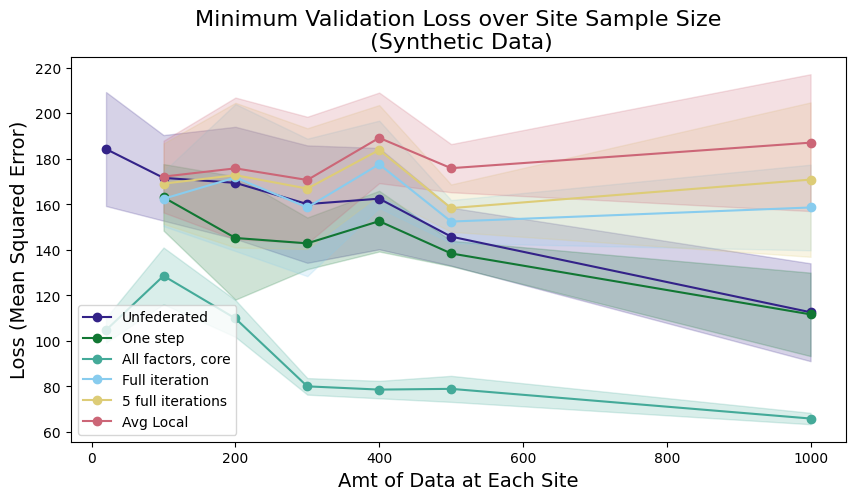

In [4]:
colors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#5D070A"]
labels = ["Unfederated", "One step", "All factors, core", "Full iteration", "5 full iterations", "Avg Local"]
#labels = names

xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]

metrics = val_losses
stds = val_std

plt.figure(figsize=(10, 5))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot([20, 100, 200, 300, 400, 500, 1000], metric, label=label, color=color, marker='o')
    plt.fill_between([20, 100, 200, 300, 400, 500, 1000], metric-std, metric+std, color=color, alpha=0.2)

plt.legend()
plt.xlabel("Amt of Data at Each Site", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Minimum Validation Loss over Site Sample Size\n (Synthetic Data)", fontsize=16)
plt.show()

In [ ]:
print("Testing...")

hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = logistic_loss
lsr_dot_params = (shape, (3, 3, 3), 2, torch.float64, torch.device('cuda'))

init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
lsr_bcd_regression(init_lsr_dot, loss_fn, vessel_dataset, vessel_val_dataset,\
                       hypers, True, True)

print("Finished without errors")

In [ ]:
# Performance testing
print("Performance Testing...")
hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.005, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("BCD_federated_stepwise(init_lsr_dot, synth_client_datasets, synth_val_dataset,\
              hypers, loss_fn, aggregator_fn, False)", sort='tottime')

In [6]:
# Perf testing
shape, ranks, separation_rank = (64, 64), (8, 8), 2
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))

loss_fn = f.mse_loss
aggregator_fn = avg_aggregation

iters = 100

n_runs = 1
n_trials = 8
n_workers = 8

path_base = "../data/synth_size_test"

def data_fn_by_size(sample_size, val_sample_size=500, clients=10):
    synth_tensor = get_synth_tensor(shape, ranks, separation_rank)
    synth_dataset, synth_val_dataset = synthesize_data(synth_tensor, sample_size, val_sample_size)
    synth_client_datasets = federate_dataset(synth_dataset, clients)
    return (synth_dataset, synth_val_dataset, synth_client_datasets)
    
def data_fn():
    return data_fn_by_size(sample_size=100)

methods = [BCD_avg_local, lsr_bcd_regression, BCD_federated_stepwise, BCD_federated_all_factors, BCD_federated_full_iteration, BCD_federated_full_iteration]
names = ['local', 'centralized', 'step', 'factors_core', 'one_iter', 'five_iter']

gen_hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_5_hypers = {"max_rounds": iters // 5, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

arg_list = [(gen_hypers, loss_fn, False), # local
            (gen_hypers, loss_fn, False), # centralized
            (gen_hypers, loss_fn, aggregator_fn, False), # one step
            (gen_hypers, loss_fn, aggregator_fn, False), # factors core
            (iter_hypers, loss_fn, aggregator_fn, False), # one iter
            (iter_5_hypers, loss_fn, aggregator_fn, False)] # five iter

cProfile.run("run_combined_test(path_base, n_runs, n_trials, n_workers, data_fn, lsr_dot_params, names, methods, arg_list)", sort='tottime')

Run 0
         26364 function calls (26049 primitive calls) in 467.216 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      767  465.750    0.607  465.750    0.607 {method 'acquire' of '_thread.lock' objects}
      285    1.180    0.004    1.180    0.004 {built-in method posix.waitpid}
       48    0.124    0.003    0.124    0.003 {built-in method _posixsubprocess.fork_exec}
        2    0.014    0.007    0.014    0.007 {built-in method torch.randn}
       48    0.010    0.000    0.175    0.004 popen_spawn_posix.py:38(_launch)
      193    0.008    0.000    0.008    0.000 socket.py:613(send)
      126    0.007    0.000    0.013    0.000 {method 'dump' of '_pickle.Pickler' objects}
       48    0.006    0.000    0.006    0.000 {built-in method io.open}
        6    0.005    0.001    0.005    0.001 {method 'acquire' of '_multiprocessing.SemLock' objects}
       48    0.005    0.000    0.263    0.005 popen_fork.py:15(__init__